# Data Analysis and Visualization for Telecom Data

This notebook performs various analyses on telecom data, including data loading, preprocessing, PCA, clustering, and visualization.


In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the path where telecom_analysis.py is located
sys.path.append(os.path.abspath('../scripts'))

# Import functions from telecom_analysis.py
from telecom_analysis import (
    load_data_using_sqlalchemy,
    preprocess_data,
    segment_users,
    perform_pca,
    cluster_users
)

# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL using SQLAlchemy
df = load_data_using_sqlalchemy(query)

# Check if data is loaded successfully
if df is not None:
    print("Successfully loaded the data")
    
    # Display the first few rows of the dataframe
    df.head()
else:
    print("Failed to load data.")


Successfully loaded the data


In [2]:
# Preprocess data
df = preprocess_data(df)

# Display the first few rows after preprocessing
df.head()


Columns in the dataframe: Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,4.258219,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,-0.387507,-0.597038
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,4.258219,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,1.133456,0.814835
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,4.258219,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,-1.178387,-0.716184
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,4.258219,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,0.198953,1.604339
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,4.258219,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,-0.227560,0.469571


In [3]:
from sklearn.metrics import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Task 4.1 - Assign Engagement and Experience Scores
def calculate_satisfaction_scores(df, engagement_cluster_center, experience_cluster_center):
    # Calculate the Euclidean distance for engagement score (less engaged cluster)
    df['engagement_score'] = euclidean_distances(
        df[['session_frequency', 'total_duration', 'total_traffic']], [engagement_cluster_center]
    ).flatten()

    # Calculate the Euclidean distance for experience score (worst experience cluster)
    df['experience_score'] = euclidean_distances(
        df[['avg_throughput', 'avg_tcp_retransmission', 'avg_rtt']], [experience_cluster_center]
    ).flatten()

    return df

# Use the cluster centers from previous tasks
engagement_cluster_center = df_engagement[['session_frequency', 'total_duration', 'total_traffic']].mean(axis=0).values
experience_cluster_center = experience_cluster_centers[2]  # Assuming the 3rd cluster is the worst experience

# Assign the scores
df_combined = calculate_satisfaction_scores(df_combined, engagement_cluster_center, experience_cluster_center)

# Task 4.2 - Calculate satisfaction score as the average of engagement and experience scores
df_combined['satisfaction_score'] = (df_combined['engagement_score'] + df_combined['experience_score']) / 2

# Report top 10 satisfied customers
top_10_satisfied_customers = df_combined.nlargest(10, 'satisfaction_score')
print("Top 10 Satisfied Customers:")
print(top_10_satisfied_customers[['MSISDN/Number', 'satisfaction_score']])

# Task 4.3 - Build a regression model to predict satisfaction score
X = df_combined[['engagement_score', 'experience_score']]
y = df_combined['satisfaction_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train the regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict satisfaction score
y_pred = regressor.predict(X_test)

# Evaluate the regression model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of Regression: {mse}")

# Task 4.4 - Run k-means clustering (k=2) on engagement and experience scores
kmeans = KMeans(n_clusters=2, random_state=0)
df_combined['kmeans_cluster'] = kmeans.fit_predict(df_combined[['engagement_score', 'experience_score']])

# Task 4.5 - Aggregate the average satisfaction & experience score per cluster
cluster_summary = df_combined.groupby('kmeans_cluster').agg({
    'satisfaction_score': 'mean',
    'experience_score': 'mean',
    'engagement_score': 'mean'
}).reset_index()

print("Cluster Summary (Average Satisfaction, Engagement, and Experience Scores):")
print(cluster_summary)


NameError: name 'df_engagement' is not defined

In [4]:
df = segment_users(df)

# Display the first few rows with decile information
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),decile
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,4.258219,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,-0.387507,-0.597038,8
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,4.258219,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,1.133456,0.814835,8
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,4.258219,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,-1.178387,-0.716184,8
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,4.258219,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,0.198953,1.604339,8
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,4.258219,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,-0.227560,0.469571,8


Explained variance by the components: [9.99744622e-01 2.55378167e-04]
Total variance explained by the components: 1.00


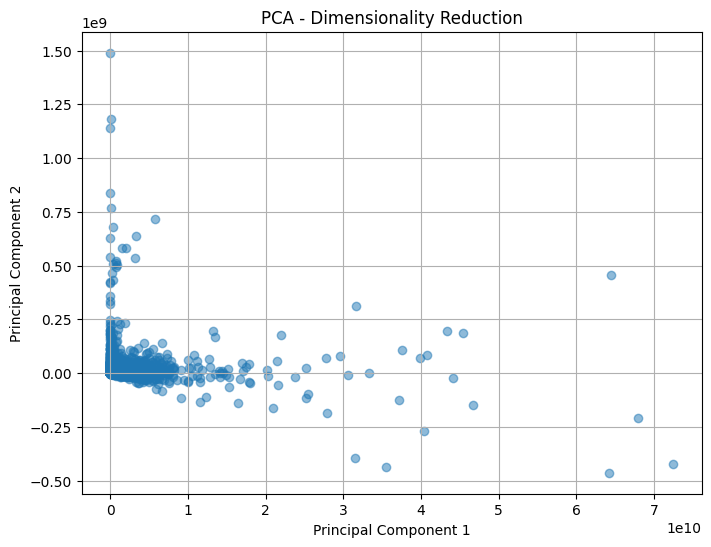

In [5]:
# Define the columns for PCA based on the available schema columns
columns_for_pca = ['Total DL (Bytes)', 'Total UL (Bytes)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)']

# Ensure that these columns are present in your DataFrame
# Perform PCA
pca_result, explained_variance, total_explained_variance = perform_pca(df, columns_for_pca)

# Display PCA results
print(f'Explained variance by the components: {explained_variance}')
print(f'Total variance explained by the components: {total_explained_variance:.2f}')

# Plot PCA result
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA - Dimensionality Reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)  # Add grid to the plot for better visualization
plt.show()


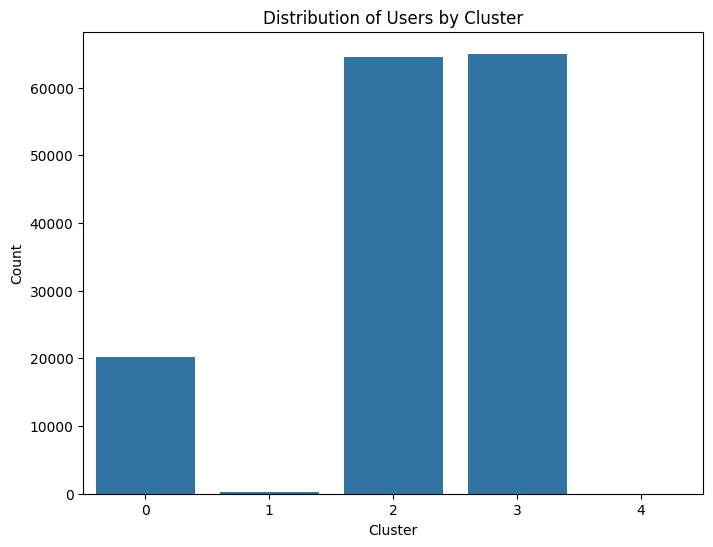

In [6]:
# Perform clustering
df, kmeans = cluster_users(df, n_clusters=5)

# Display the first few rows with cluster information
df.head()

# Plot cluster distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster', data=df)
plt.title('Distribution of Users by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


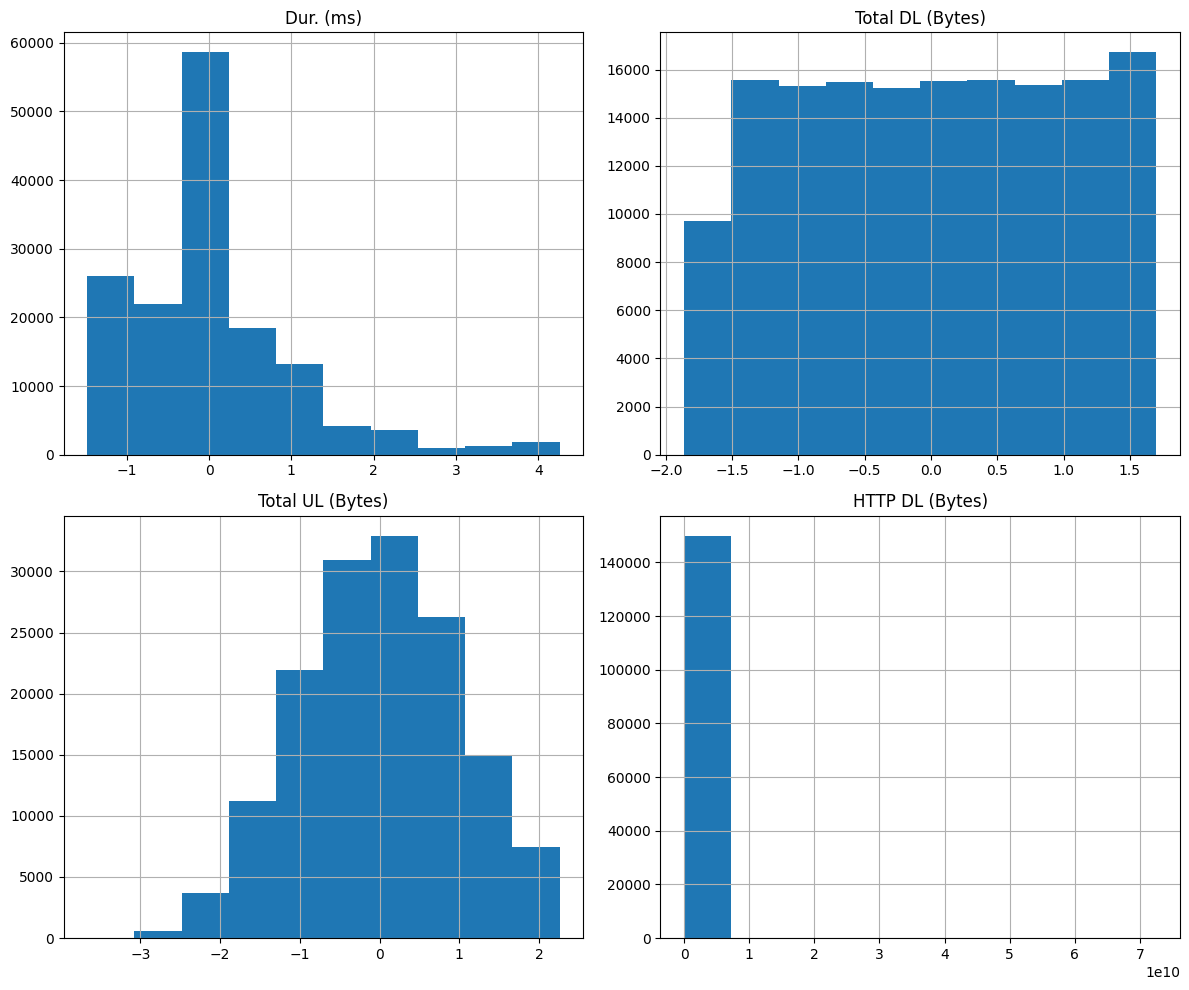

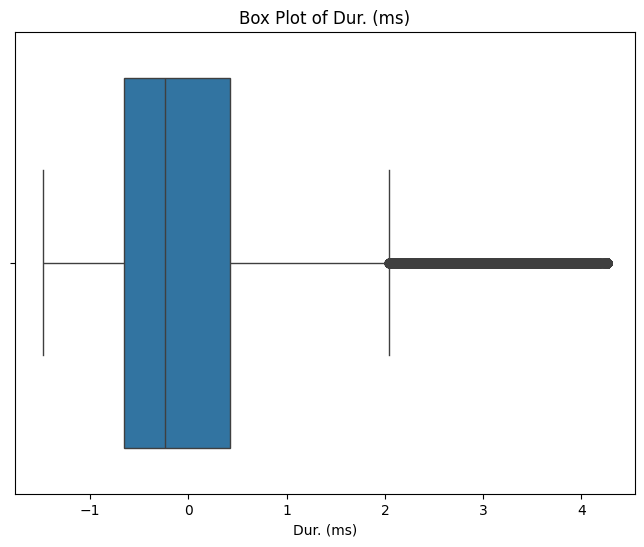

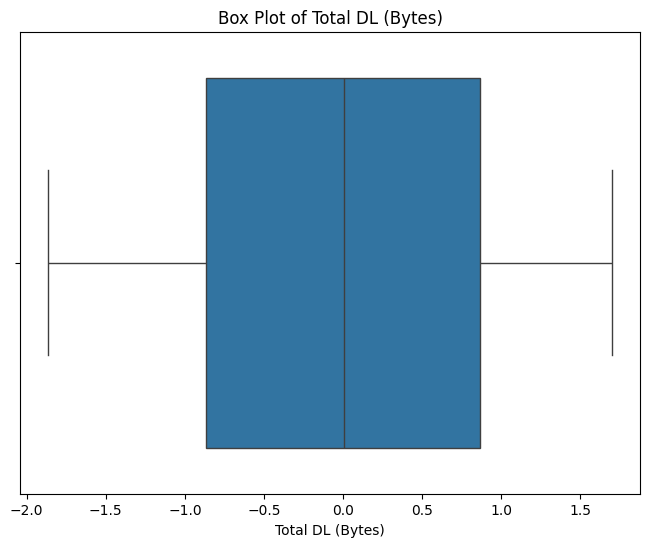

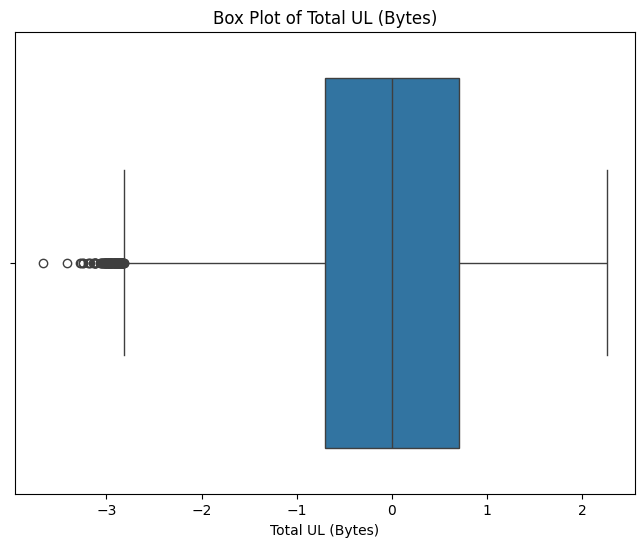

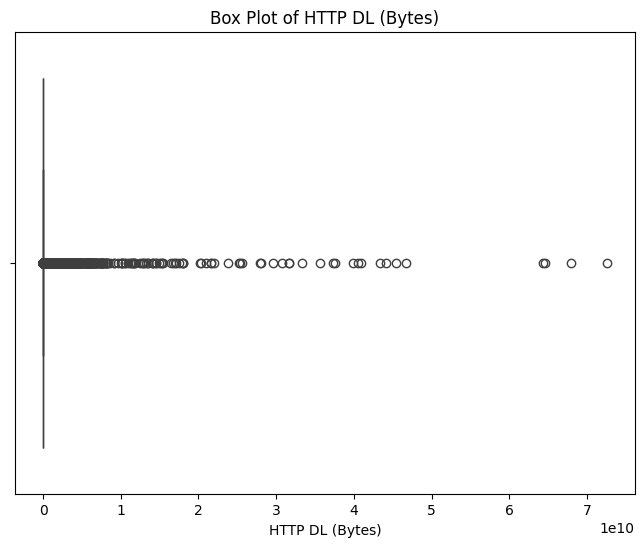

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Replace with actual column names from your schema
columns_for_visualization = ['Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)', 'HTTP DL (Bytes)']  # Adjusted column names

# Histograms of user behavior metrics
df[columns_for_visualization].hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# Box plots of user behavior metrics
for column in columns_for_visualization:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)  # Add label for clarity
    plt.show()


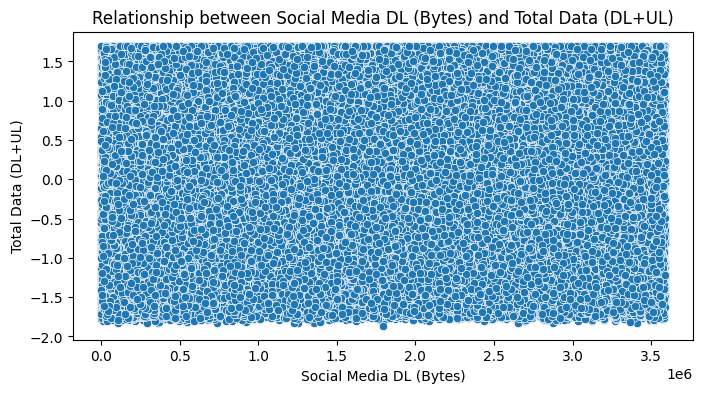

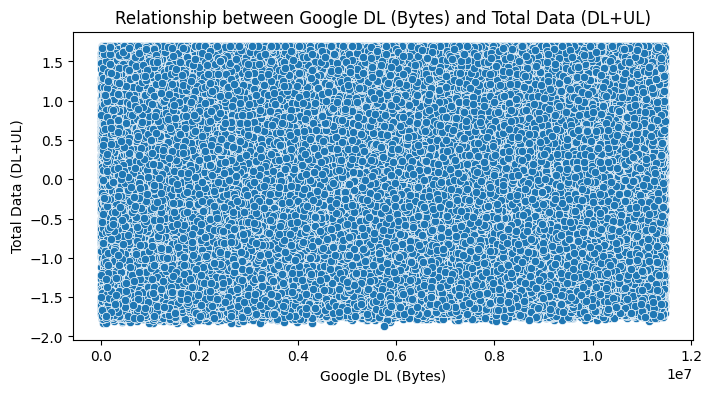

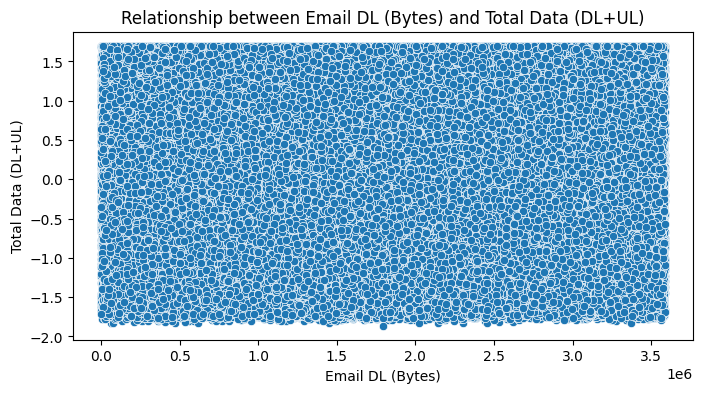

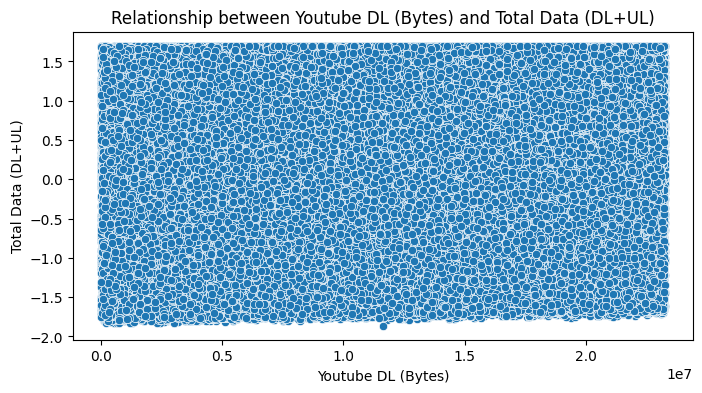

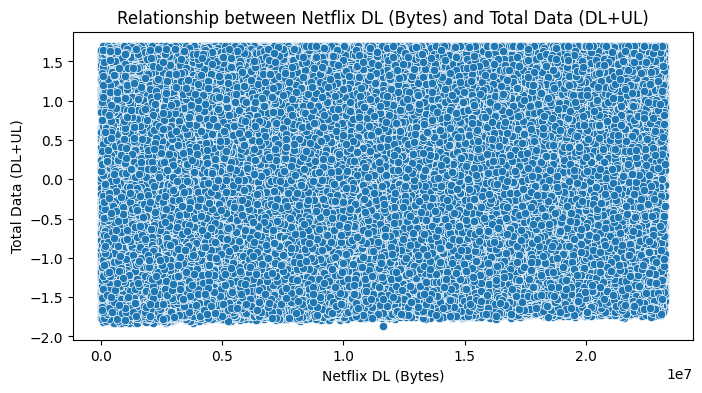

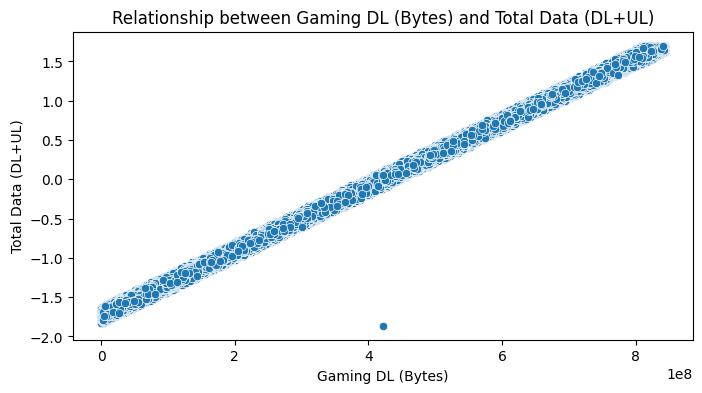

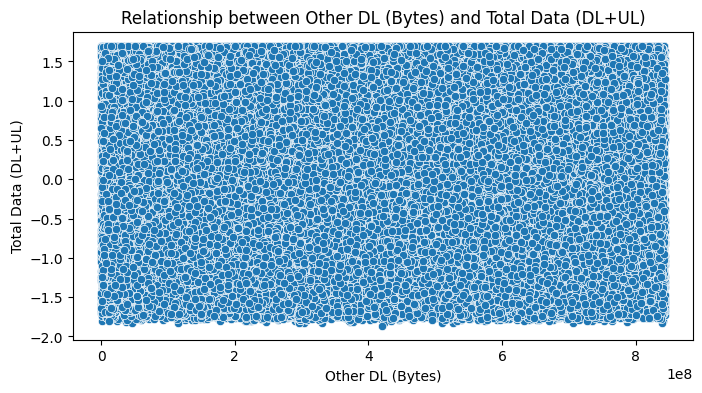

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define application columns and total data column based on your schema
application_columns = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']
total_data_column = 'Total DL (Bytes)'  # Assuming 'Total DL (Bytes)' includes both download and upload data

# Scatter plots to explore relationships between applications and total data
for app in application_columns:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=df[app], y=df[total_data_column])
    plt.title(f'Relationship between {app} and Total Data (DL+UL)')
    plt.xlabel(f'{app}')
    plt.ylabel('Total Data (DL+UL)')
    plt.show()


Correlation Matrix:
                         Social Media DL (Bytes)  Google DL (Bytes)  \
Social Media DL (Bytes)                 1.000000          -0.001954   
Google DL (Bytes)                      -0.001954           1.000000   
Email DL (Bytes)                        0.004745          -0.000039   
Youtube DL (Bytes)                     -0.001389           0.001760   
Netflix DL (Bytes)                     -0.001817           0.000548   
Gaming DL (Bytes)                       0.001018          -0.001421   
Other DL (Bytes)                        0.006126          -0.002557   

                         Email DL (Bytes)  Youtube DL (Bytes)  \
Social Media DL (Bytes)          0.004745           -0.001389   
Google DL (Bytes)               -0.000039            0.001760   
Email DL (Bytes)                 1.000000            0.001679   
Youtube DL (Bytes)               0.001679            1.000000   
Netflix DL (Bytes)               0.001351            0.001202   
Gaming DL (Bytes)    

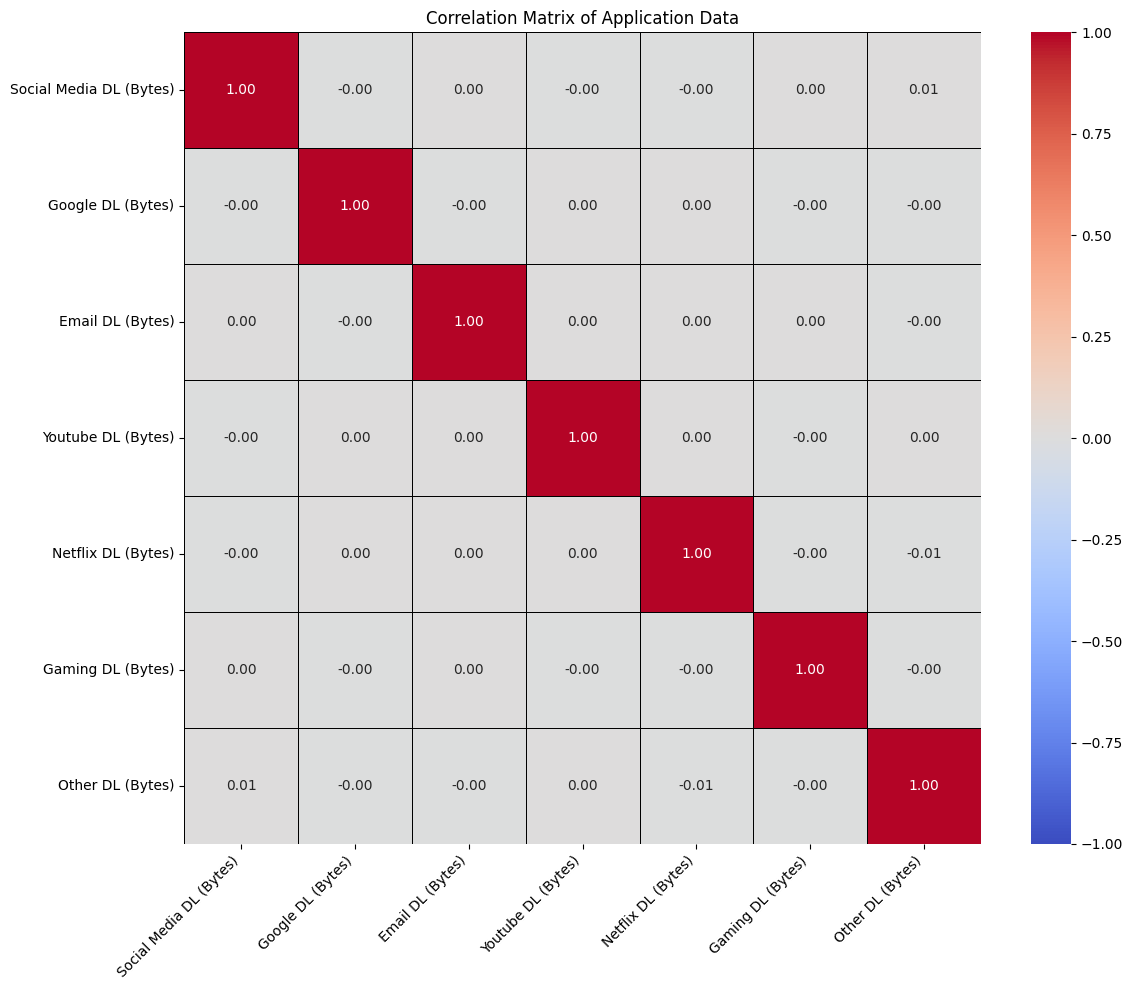

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct column names for correlation analysis
correlation_columns = [
    'Social Media DL (Bytes)', 
    'Google DL (Bytes)', 
    'Email DL (Bytes)', 
    'Youtube DL (Bytes)', 
    'Netflix DL (Bytes)', 
    'Gaming DL (Bytes)', 
    'Other DL (Bytes)'
]

# Calculate the correlation matrix
correlation_matrix = df[correlation_columns].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix of Application Data')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust the layout to ensure everything fits
plt.show()


In [11]:
# Summary statistics and missing values
print(df.describe())
print(df.isnull().sum())

          Bearer Id       Start ms         End ms     Dur. (ms)          IMSI  \
count  1.500010e+05  150001.000000  150001.000000  1.500010e+05  1.500010e+05   
mean   1.007189e+19     499.184872     498.797555  5.608513e-17  2.074105e+14   
std    2.998300e+18     288.613750     288.099572  1.000003e+00  1.281002e+13   
min    0.000000e+00       0.000000       0.000000 -1.480703e+00  0.000000e+00   
25%    7.349883e+18     250.000000     251.000000 -6.541424e-01  2.082010e+14   
50%    7.349883e+18     499.000000     500.000000 -2.373365e-01  2.082015e+14   
75%    1.304243e+19     749.000000     750.000000  4.250948e-01  2.082018e+14   
max    1.318654e+19     999.000000     999.000000  4.258219e+00  2.140743e+14   

       MSISDN/Number          IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
count   1.500010e+05  1.500010e+05    150001.000000    150001.000000   
mean    4.158517e+10  4.828970e+13        89.425810        14.387971   
std     2.438734e+12  2.257219e+13       560.968602   

Successfully loaded the data


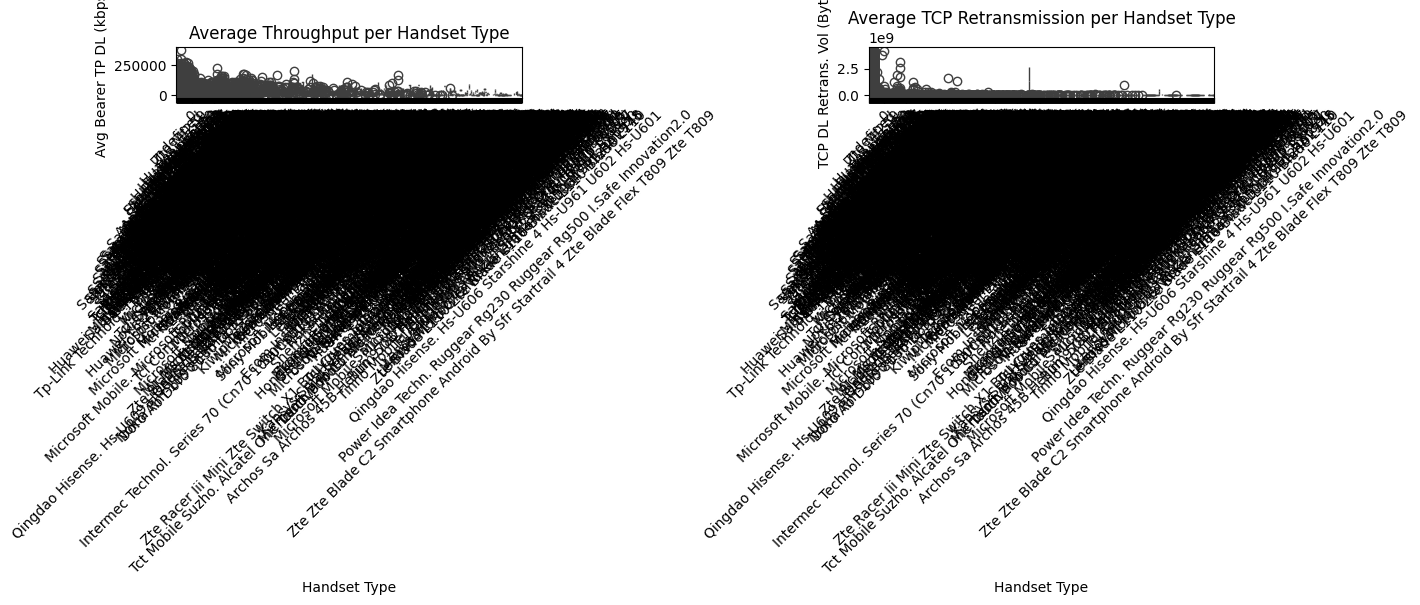

Cluster Centers (Original Scale):
   Avg Bearer TP DL (kbps)  TCP DL Retrans. Vol (Bytes)  Avg RTT DL (ms)
0              3822.984142                 1.174042e+06       100.354986
1             49243.793112                 1.785503e+07        75.622271
2             62883.362083                 2.224066e+09       104.356875

Cluster 0 Statistics:
       Avg Bearer TP DL (kbps)  TCP DL Retrans. Vol (Bytes)  Avg RTT DL (ms)
count             88768.000000                 8.876800e+04     88768.000000
mean               3816.563975                 1.172921e+06       100.357639
std                6953.431960                 1.088321e+07       635.116605
min                   0.000000                 0.000000e+00         0.000000
25%                  41.000000                 0.000000e+00        19.000000
50%                  60.000000                 0.000000e+00        34.000000
75%                4136.250000                 9.310000e+03        55.000000
max               28379.000000     

In [12]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Append the script directory to sys.path
sys.path.append(os.path.abspath('../scripts'))

from telecom_analysis import load_data_using_sqlalchemy

# Load data from PostgreSQL
query = "SELECT * FROM xdr_data;"  # Adjust as needed
df = load_data_using_sqlalchemy(query)

if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

# Task 3.1 - Aggregate per customer
def clean_and_aggregate(df):
    df.fillna({
        'TCP DL Retrans. Vol (Bytes)': df['TCP DL Retrans. Vol (Bytes)'].mean(),
        'Avg RTT DL (ms)': df['Avg RTT DL (ms)'].mean(),
        'Avg Bearer TP DL (kbps)': df['Avg Bearer TP DL (kbps)'].mean(),
        'Handset Type': df['Handset Type'].mode()[0]  # Fill missing Handset Type with mode
    }, inplace=True)
    
    # Replace infinities with NaN and fill again
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna({
        'TCP DL Retrans. Vol (Bytes)': df['TCP DL Retrans. Vol (Bytes)'].mean(),
        'Avg RTT DL (ms)': df['Avg RTT DL (ms)'].mean(),
        'Avg Bearer TP DL (kbps)': df['Avg Bearer TP DL (kbps)'].mean()
    }, inplace=True)
    
    # Aggregate data per customer
    aggregated = df.groupby('IMEI').agg({
        'TCP DL Retrans. Vol (Bytes)': 'mean',
        'Avg RTT DL (ms)': 'mean',
        'Avg Bearer TP DL (kbps)': 'mean',
        'Handset Type': 'first'  # Assuming handset type doesn't change per user
    }).reset_index()

    return aggregated

aggregated_df = clean_and_aggregate(df)

# Task 3.2 - Compute & list top, bottom, and most frequent values
def compute_statistics(df):
    # Top 10 values
    top_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)
    bottom_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)
    frequent_tcp = df['TCP DL Retrans. Vol (Bytes)'].mode()
    
    top_10_rtt = df['Avg RTT DL (ms)'].nlargest(10)
    bottom_10_rtt = df['Avg RTT DL (ms)'].nsmallest(10)
    frequent_rtt = df['Avg RTT DL (ms)'].mode()
    
    top_10_throughput = df['Avg Bearer TP DL (kbps)'].nlargest(10)
    bottom_10_throughput = df['Avg Bearer TP DL (kbps)'].nsmallest(10)
    frequent_throughput = df['Avg Bearer TP DL (kbps)'].mode()
    
    # Print or return statistics
    print("\nTop 10 TCP Retransmission Values:")
    print(top_10_tcp)
    
    print("\nBottom 10 TCP Retransmission Values:")
    print(bottom_10_tcp)
    
    print("\nMost Frequent TCP Retransmission Values:")
    print(frequent_tcp)
    
    print("\nTop 10 RTT Values:")
    print(top_10_rtt)
    
    print("\nBottom 10 RTT Values:")
    print(bottom_10_rtt)
    
    print("\nMost Frequent RTT Values:")
    print(frequent_rtt)
    
    print("\nTop 10 Throughput Values:")
    print(top_10_throughput)
    
    print("\nBottom 10 Throughput Values:")
    print(bottom_10_throughput)
    
    print("\nMost Frequent Throughput Values:")
    print(frequent_throughput)
    
    return {
        'top_10_tcp': top_10_tcp,
        'bottom_10_tcp': bottom_10_tcp,
        'frequ  ent_tcp': frequent_tcp,
        'top_10_rtt': top_10_rtt,
        'bottom_10_rtt': bottom_10_rtt,
        'frequent_rtt': frequent_rtt,
        'top_10_throughput': top_10_throughput,
        'bottom_10_throughput': bottom_10_throughput,
        'frequent_throughput': frequent_throughput
    }
stats_summary = compute_statistics(df)

# Task 3.3 - Distribution of average throughput and TCP retransmission
def compute_and_plot_distributions(df):
    # Aggregate data by handset type
    aggregated_data = df.groupby('Handset Type').agg({
        'Avg Bearer TP DL (kbps)': 'mean',
        'TCP DL Retrans. Vol (Bytes)': 'mean'
    }).reset_index()
    
    # Distribution of average throughput per handset type
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='Handset Type', y='Avg Bearer TP DL (kbps)', data=df)
    plt.title('Distribution of Average Throughput per Handset Type')
    plt.xticks(rotation=45)

    # Distribution of average TCP retransmission per handset type
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Handset Type', y='TCP DL Retrans. Vol (Bytes)', data=df)
    plt.title('Distribution of Average TCP Retransmission per Handset Type')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
    
    # Print the aggregated data for interpretation
    print("Aggregated Data by Handset Type:")
    print(aggregated_data)

# Assuming df is your DataFrame
compute_and_plot_distributions(df)

# Task 3.4 - K-Means Clustering
#
def perform_kmeans_clustering(df, n_clusters=3):
    # Prepare the data for clustering
    features = df[['Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)']].copy()
    features.fillna(features.mean(), inplace=True)  # Handle missing values by replacing with the mean
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    df['Cluster'] = kmeans.fit_predict(scaled_features)
    
    # Inverse transform the cluster centers to original scale
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=['Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)'])
    
    # Display cluster centers
    print("Cluster Centers (Original Scale):")
    print(cluster_centers_df)
    
    return df

def describe_clusters(df):
    cluster_description = df.groupby('Cluster').agg({
        'Avg Bearer TP DL (kbps)': ['mean', 'std'],
        'TCP DL Retrans. Vol (Bytes)': ['mean', 'std'],
        'Avg RTT DL (ms)': ['mean', 'std'],
        'IMEI': 'count'
    }).reset_index()
    
    print("\nCluster Descriptions:")
    print(cluster_description)

    # Plot the clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Avg Bearer TP DL (kbps)', y='TCP DL Retrans. Vol (Bytes)', hue='Cluster', data=df, palette='Set1')
    plt.title('K-Means Clustering of Users')
    plt.xlabel('Average Throughput (kbps)')
    plt.ylabel('Average TCP Retransmission (Bytes)')
    plt.legend(title='Cluster')
    plt.show()

# Assuming df is your DataFrame
clustered_df = perform_kmeans_clustering(df)
describe_clusters(clustered_df)
